In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
import jax.random as jr
import pandas as pd

from uncprop.utils.experiment import Experiment
from uncprop.models.elliptic_pde.experiment import PDEReplicate

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jr.key(7932523)
key, key_experiment = jr.split(key)

experiment_name = 'pde_experiment'
experiment_settings = {
    'name': experiment_name,
    'base_out_dir': base_dir / 'out' / experiment_name,
    'num_reps': 1,
    'base_key': key_experiment,
    'Replicate': PDEReplicate,
    'write_to_file': True,
}

noise_sd = 1e-3
obs_locations = jnp.array([10, 30, 60, 75])
setup_kwargs = {
    'n_design': 12,
    'obs_locations': obs_locations,
    'noise_cov': noise_sd**2 * jnp.identity(len(obs_locations)),
}

def make_subdir_name(setup_kwargs, run_kwargs):
    n = setup_kwargs['n_design']
    return f'n_design_{n}'

run_kwargs = {
    'n_warmup': 50_000
}

pde_experiment = Experiment(subdir_name_fn=make_subdir_name, 
                            **experiment_settings)



Creating new output directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment


In [3]:
results, failed_reps = pde_experiment(setup_kwargs=setup_kwargs, run_kwargs=run_kwargs)

Creating experiment sub-directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment/n_design_12
Running replicate 0
	Fitting surrogate
	Running samplers
No save_results() methods implemented.
0 of 1 replicates failed.


In [4]:
rep = results[0]
posterior = rep.posterior

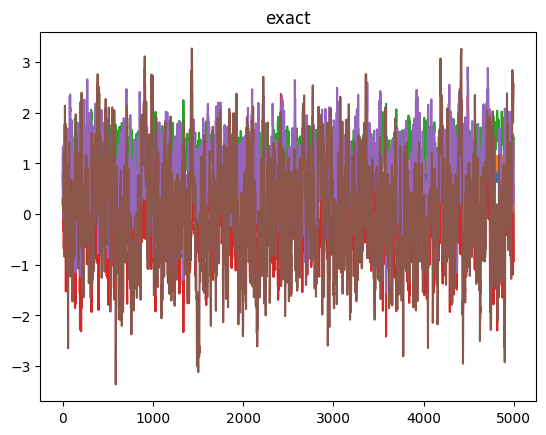

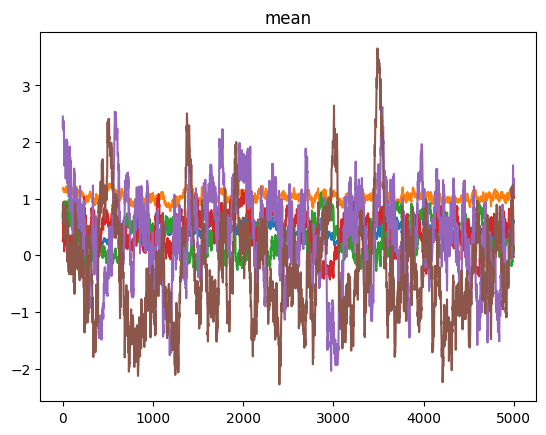

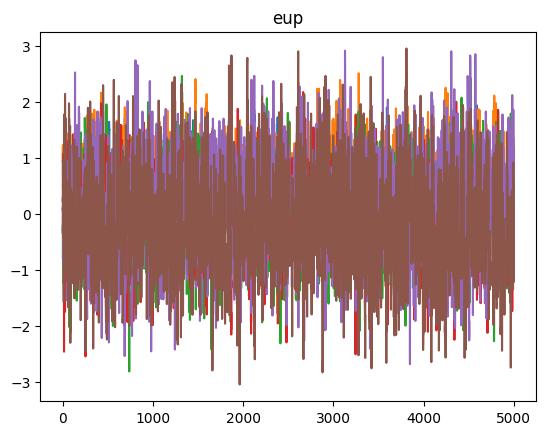

In [5]:
for mcmc_tag in ['exact', 'mean', 'eup']:
    samp = rep.samples[mcmc_tag]
    for i in range(posterior.dim):
        plt.plot(samp[:,i])
        plt.title(mcmc_tag)
    plt.show()

In [ ]:
key_prior_samp, key = jr.split(key)

samples = rep.samples
samples['prior'] = posterior.prior.sample(key_prior_samp, n=samples['exact'].shape[0])

In [ ]:
key_subsamp, key = jr.split(key)

dist1_name = 'exact'
dist2_name = 'eup'

dist_names = ['prior', 'eup', 'mean', 'exact']

df_list = []
for name in dist_names:
    df = pd.DataFrame(samples[name], columns=posterior.prior.par_names)
    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

# idx = jr.choice(key_subsamp, samp.shape[0], (10_000,))
# post_samp_df = pd.DataFrame(samp[idx], columns=posterior.prior.par_names)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

In [ ]:
postsamp = samp[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()


### Test RFF approximation

In [6]:
from collections.abc import Callable

import jax
import jax.numpy as jnp
from gpjax.gps import _build_fourier_features_fn
from gpjax.kernels.approximations import RFF
from numpyro.distributions import MultivariateNormal

from uncprop.core.surrogate import GPJaxSurrogate
from uncprop.utils.gpjax_multioutput import BatchIndependentGP
from uncprop.core.distribution import GaussianFromNumpyro
from uncprop.custom_types import PRNGKey, Array

surrogate = rep.posterior_surrogate.surrogate
batchgp = rep.batchgp
input = posterior.prior.sample(key, 20)

In [7]:
from uncprop.utils.gpjax_multioutput import (
    sample_approx_trajectory,
    _build_batch_basis_funcs,
    _build_batch_basis_noise_dist,
)

num_rff = 1000

basis_fn = _build_batch_basis_funcs(key, surrogate, batchgp, num_rff=num_rff)
dist = _build_batch_basis_noise_dist(surrogate=surrogate,
                                     batchgp=batchgp,
                                     num_rff=num_rff)

In [10]:
noise_realizations = dist.sample(key, 10_000)

trajectories = sample_approx_trajectory(basis_fn=basis_fn,
                                        noise_realization=noise_realizations, 
                                        surrogate=surrogate,
                                        num_rff=num_rff)

In [31]:
from gpjax import Dataset

def sample_approx(
        batchgp,
        surrogate,
        num_samples: int,
        train_data: Dataset,
        key,
        num_features: int | None = 100,
    ):

        t = num_samples
        q = surrogate.output_dim
        n = train_data.n
        b = 2 * num_features

        if (not isinstance(t, int)) or t <= 0:
            raise ValueError("num_samples must be a positive integer")

        # sample fourier features
        funcs = [_build_fourier_features_fn(post.prior, num_features, key) for post in batchgp.posterior_list]
        def fourier_feature_fn(test_inputs):
            return jnp.stack([fn(test_inputs) for fn in funcs])

        fourier_weights = jr.normal(key, [t, q, b]) # (t, q, b)

        obs_var = surrogate.gp.likelihood.obs_stddev.get_value() ** 2 # (q,)
        Kxx = surrogate.prior_gram(train_data.X) # (q, n, n)
        Sigma = Kxx + surrogate._get_jitter_matrix(n) # (q, n, n)

        # TODO: left off here
        # eps = jnp.sqrt(obs_var) * jr.normal(key, [train_data.n, num_samples])
        eps = jnp.sqrt(obs_var)[None, :, None] * jr.normal(key, [t, q, n]) # (t, q, n)
        y = train_data.y - surrogate.gp.prior.mean_function(train_data.X) # (n, q)
        y = y.T # (q, n)
        Phi = fourier_feature_fn(train_data.X) # (q, n, b)

        Phi_X_w = Phi[None] @ fourier_weights[..., None] # (1, q, n, b) @ (t, q, b, 1)
        Phi_X_w = Phi_X_w.squeeze(-1) # (t, q, n)
        rhs = y[None] + eps - Phi_X_w # (1, q, n) + (t, q, n) + (t, q, n) = (t, q, n)

        canonical_weights = jnp.linalg.solve(
            jnp.broadcast_to(Sigma, (t, q, n, n)), # (t, q, n, n)
            rhs[..., None] # (t, q, n, 1)
        ).squeeze(-1) # (t, q, n)

        def sample_fn(test_inputs):
            fourier_features = fourier_feature_fn(test_inputs) # (q, m, b)
            weight_space_contribution = fourier_features[None] @ fourier_weights[..., None] # (1, q, m, b) @ (t, q, b) = (t, q, m, 1)
            weight_space_contribution = weight_space_contribution.squeeze(-1) # (t, q, m)
            # weight_space_contribution = jnp.inner(fourier_features, fourier_weights) # (m, b) (t, b) -> (m, t)
            
            canonical_features = surrogate.prior_cross_covariance(test_inputs, train_data.X) # (q, m, n)
            function_space_contribution = canonical_features[None] @ canonical_weights[..., None] # (1, q, m, n) @ (t, q, n, 1) = (t, q, m, 1)
            function_space_contribution = function_space_contribution.squeeze(-1) # (t, q, m)

            return (
                surrogate.gp.prior.mean_function(test_inputs).T[None] # (1, q, m)
                + weight_space_contribution # (t, q, m)
                + function_space_contribution # (t, q, m)
            )

        return sample_fn

In [35]:
traj = sample_approx(
        batchgp,
        surrogate,
        num_samples=10_000,
        train_data=surrogate.design,
        key=key,
        num_features=1000,
    )

In [33]:
tester = traj(input)

In [34]:
tester.shape

(10, 4, 20)

/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_46964/3698976800.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


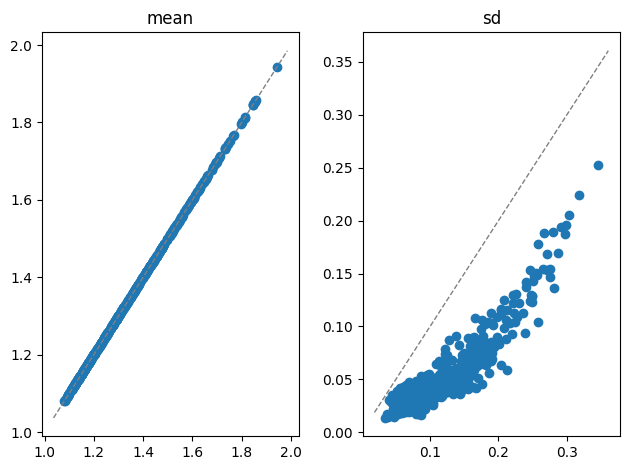

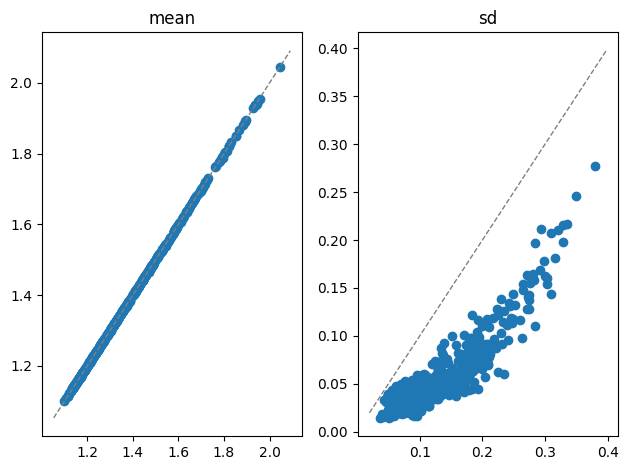

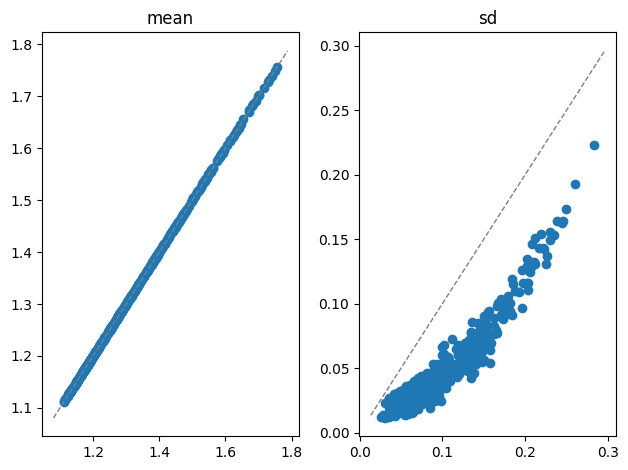

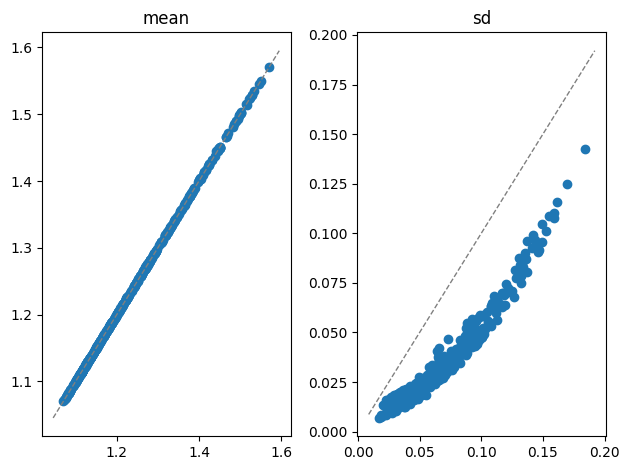

In [37]:
def check_rff_approx(key, posterior, surrogate, trajectories, n_test=500):
    inputs = posterior.prior.sample(key, n_test)

    pred = surrogate(inputs)
    pred_rff = trajectories(inputs)
    m = pred.mean
    sd = pred.stdev
    m_rff = jnp.mean(pred_rff, axis=0)
    sd_rff = jnp.std(pred_rff, axis=0)

    for i in range(surrogate.output_dim):
        fig, axs = plt.subplots(1, 2)
        axs = axs.ravel()
        axs[0].scatter(m[i], m_rff[i])
        axs[0].set_title('mean')
        xmin, xmax = axs[0].get_xlim()
        ymin, ymax = axs[0].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[0].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        axs[1].scatter(sd[i], sd_rff[i])
        axs[1].set_title('sd')
        xmin, xmax = axs[1].get_xlim()
        ymin, ymax = axs[1].get_ylim()
        grid = jnp.linspace(xmin, xmax, 100)
        axs[1].plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')

        fig.tight_layout()
        fig.show()

key_plot, key = jr.split(key)
check_rff_approx(key, posterior, surrogate, traj)


/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_46964/4282013830.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/8y/dh1rsmhx3y13wxw2h2f713qm0000gn/T/ipykernel_46964/4282013830.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


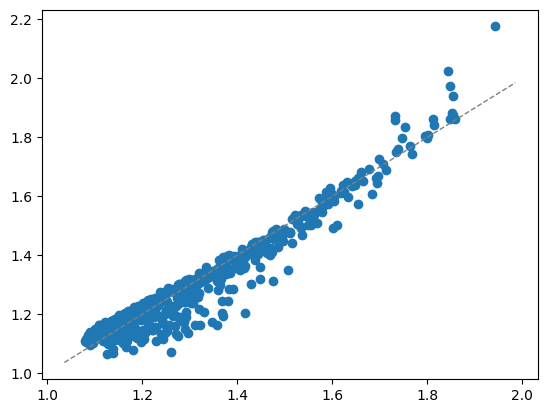

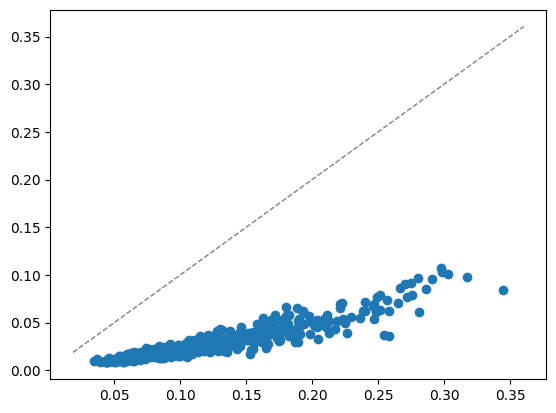

In [40]:
import gpjax as gpx
from gpjax import Dataset

out_idx = 0

D = Dataset(surrogate.design.X, surrogate.design.y[:,[out_idx]])
post1: gpx.gps.ConjugatePosterior = batchgp.posterior_list[out_idx]
traj = post1.sample_approx(num_samples=50_000,
                           train_data=D,
                           key=key,
                           num_features=1000)

inputs = posterior.prior.sample(key, 500)
# samp = traj(inputs)
# m_rff = jnp.mean(samp, axis=1)
# sd_rff = jnp.std(samp, axis=1)

pred_post1 = post1(inputs, D)
m_rff = pred_post1.mean
sd_rff = jnp.sqrt(pred_post1.variance)

pred = surrogate(inputs)
# pred = post1(inputs, D)
mean = pred.mean[out_idx]
sd = jnp.sqrt(pred.variance)[out_idx]

fig, ax = plt.subplots()
ax.scatter(mean, m_rff)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
grid = jnp.linspace(xmin, xmax, 100)
ax.plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')
fig.show()

fig, ax = plt.subplots()
ax.scatter(sd, sd_rff)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
grid = jnp.linspace(xmin, xmax, 100)
ax.plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')
fig.show()

In [62]:
def test_batch_gp(surrogate, batchgp, train_data, test_inputs):
    test_batch_gp_hyperpars(surrogate, batchgp)
    test_batch_gp_pred(surrogate, batchgp, train_data, test_inputs)


def test_batch_gp_hyperpars(surrogate, batchgp):
    posts = batchgp.posterior_list

    # hyperparameters
    l_surr = surrogate.gp.prior.kernel.lengthscale.get_value()
    l_posts = jnp.array([post.prior.kernel.lengthscale.get_value() for post in posts])

    v_surr = surrogate.gp.prior.kernel.variance
    v_posts = jnp.array([post.prior.kernel.variance.get_value() for post in posts])

    obs_sd_surr = surrogate.gp.likelihood.obs_stddev.get_value()
    obs_sd_posts = jnp.array([post.likelihood.obs_stddev.get_value() for post in posts])

    m_surr = surrogate.gp.prior.mean_function.constant.get_value()
    m_posts = jnp.array([post.prior.mean_function.constant.get_value() for post in posts])

    print('lengthscales equal:', jnp.array_equal(l_surr, l_posts))
    print('variances equal:', jnp.array_equal(v_surr, v_posts))
    print('obs stdevs equal:', jnp.array_equal(obs_sd_surr, obs_sd_posts))
    print('obs stdevs equal:', jnp.array_equal(m_surr, m_posts))


def test_batch_gp_pred(surrogate, batchgp, train_data, test_inputs):
    post_list = batchgp.posterior_list
    pred_surr = surrogate(test_inputs)
    surr_mean = pred_surr.mean
    surr_var = pred_surr.variance

    for i in range(batchgp.dim_out):
        pred_post = post_list[i](test_inputs, train_data)
        print(f'output {i+1} predictions:')
        print(f'\tMeans equal: {jnp.array_equal(surr_mean[i], pred_post.mean)}')
        print(f'\tVariances equal: {jnp.array_equal(surr_var[i], pred_post.variance)}')

In [63]:
test_batch_gp(surrogate, batchgp, surrogate.design, input)

lengthscales equal: True
variances equal: True
obs stdevs equal: True
obs stdevs equal: True
output 1 predictions:
	Means equal: False
	Variances equal: False
output 2 predictions:
	Means equal: False
	Variances equal: False
output 3 predictions:
	Means equal: False
	Variances equal: False
output 4 predictions:
	Means equal: False
	Variances equal: False


### Test

In [ ]:
key_init, key_run, key_surrogate = jr.split(key, 3)

rep = PDEReplicate(key_init)
rep(key_run, write_to_file=False)
posterior = rep.posterior
forward_model = posterior.likelihood.forward_model

In [ ]:
test = {'a': 1, 'b': 2}
keys = [3, 4]

for key, (k, v) in zip(keys, test.items()):
    print(key, k, v)

In [ ]:
from uncprop.models.elliptic_pde.surrogate import fit_pde_surrogate


design, surrogate, history = fit_pde_surrogate(key=key_surrogate,
                                               posterior=posterior,
                                               n_design=60,
                                               design_method='lhc')

In [ ]:
key_prior, key = jr.split(key)

xtest = posterior.prior.sample(key_prior, 200)
f_true = forward_model(xtest)
pred = surrogate(xtest)

In [ ]:
for i in range(f_true.shape[1]):
    sns.scatterplot(x=f_true[:,i], y=pred.mean[i], color='blue')
    plt.errorbar(f_true[:,i], pred.mean[i], yerr=pred.stdev[i], fmt='none', ecolor='blue', alpha=0.5)
    plt.plot(f_true[:,i], f_true[:,i], 'r--', label="Ground truth")
    plt.xlabel('true')
    plt.ylabel('surrogate')
    plt.legend()
    plt.title(f'KL mode {i+1}')
    plt.show()